#Cortar la región de interés - formato torch.tensor

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# Cargar las imágenes proporcionadas
campo_generado_path = "campo_generado.png"
campo_real_path = "campo_real.png"

campo_generado = Image.open(campo_generado_path)
campo_real = Image.open(campo_real_path)

# Convertir las imágenes a NumPy para inspeccionar sus dimensiones y recortar
campo_generado_array = np.array(campo_generado)
campo_real_array = np.array(campo_real)

# Verificar dimensiones iniciales de ambas imágenes
campo_generado_array.shape, campo_real_array.shape


((741, 1192, 3), (741, 1192, 3))

(-0.5, 1191.5, 740.5, -0.5)

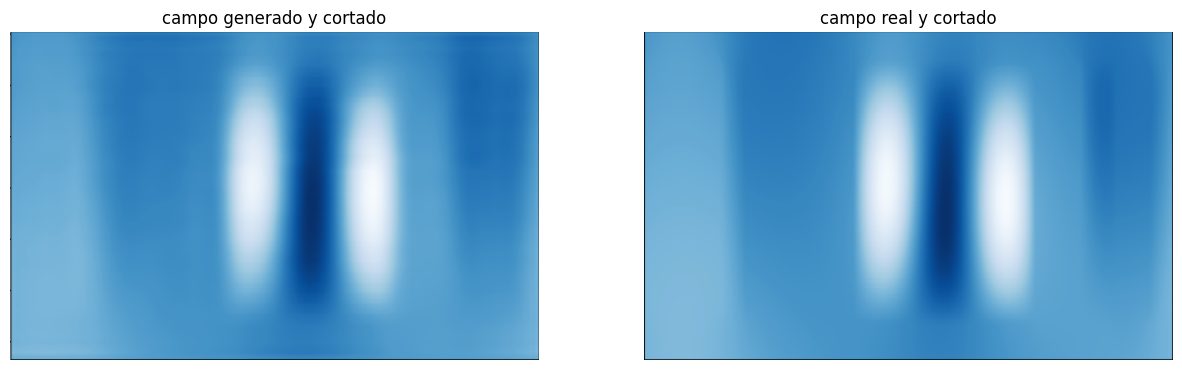

In [ ]:
# Función para recortar la región azul automáticamente
def crop_blue_region(image_array, margin_top=0, margin_bottom=0, margin_left=0, margin_right=0):
    """
    Recorta una región central azul de la imagen, excluyendo márgenes adicionales especificados.
    """
    # Suponiendo que la región azul ocupa la mayor parte de la imagen menos los márgenes
    height, width, _ = image_array.shape
    cropped = image_array[margin_top:height - margin_bottom, margin_left:width - margin_right]
    return cropped

# Márgenes observados (estimados manualmente)
margins = {
    "margin_top": 0,   # Eliminar título y parte superior
    "margin_bottom": 0, # Eliminar parte inferior
    "margin_left": 0,  # Eliminar ejes laterales
    "margin_right": 0  # Eliminar barra de color
}

# Aplicar recortes a ambas imágenes
campo_generado_cropped = crop_blue_region(campo_generado_array, **margins)
campo_real_cropped = crop_blue_region(campo_real_array, **margins)

# Verificar las nuevas dimensiones recortadas
campo_generado_cropped.shape, campo_real_cropped.shape


fig, axes = plt.subplots(1,2, figsize=(15,8))
axes[0].imshow(campo_generado_cropped)
axes[0].set_title('campo generado y cortado')
axes[0].axis('off')

axes[1].imshow(campo_real_cropped)
axes[1].set_title('campo real y cortado')
axes[1].axis('off')

In [ ]:
import torch

# Convertir las imágenes recortadas a formato de tensor
campo_generado_tensor = torch.tensor(campo_generado_cropped, dtype=torch.float32).permute(2, 0, 1) / 255.0
campo_real_tensor = torch.tensor(campo_real_cropped, dtype=torch.float32).permute(2, 0, 1) / 255.0

# Verificar las dimensiones de los tensores
campo_generado_tensor.shape, campo_real_tensor.shape


(torch.Size([3, 741, 1192]), torch.Size([3, 741, 1192]))

#Dummy Test

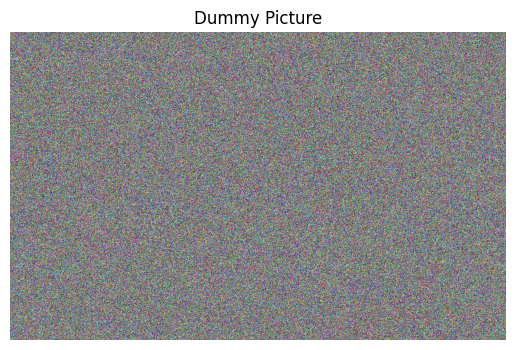

torch.Size([3, 741, 1192])


<Figure size 640x480 with 0 Axes>

In [ ]:
import torch
import matplotlib.pyplot as plt

# Generar una imagen aleatoria con valores entre 0 y 1
dummy_picture_torch = torch.rand(campo_real_tensor.shape)

# Convertir de CHW a HWC para matplotlib
dummy_picture_hwc = dummy_picture_torch.permute(1, 2, 0)

# Visualizar la imagen
plt.imshow(dummy_picture_hwc)
plt.title("Dummy Picture")
plt.axis("off")  # Opcional: Ocultar los ejes
plt.show()

print(dummy_picture_torch.size())
plt.savefig("dummy_picture.png", format="png")

#Primer Método - SSIM - Structural Similarity Index

el SSIM (Structural Similarity Index) tiene en cuenta factores como la luminancia, el contraste y la estructura en las imágenes, lo que lo convierte en un mejor indicador de similitud visual, especialmente cuando se trata de diferencias perceptuales

In [ ]:
from skimage.metrics import structural_similarity as ssim

# Convertir las imágenes de tensores a numpy arrays y reorganizar los ejes
campo_generado_np = campo_generado_tensor.permute(1, 2, 0).numpy()  # (alto, ancho, canales)
campo_real_np = campo_real_tensor.permute(1, 2, 0).numpy()          # (alto, ancho, canales)

# Asegurarse de que el tamaño de la ventana no exceda las dimensiones más pequeñas de las imágenes
min_dim = min(campo_generado_np.shape[0], campo_generado_np.shape[1])
win_size = min(5, min_dim)  # Elige 5 como tamaño estándar (debe ser impar y <= dimensión mínima)

# Calcular el SSIM sin descomponer en dos variables (solo devuelve un único valor)
ssim_value = ssim(
    campo_generado_np,
    campo_real_np,
    win_size=5,           # Tamaño de ventana ajustado
    multichannel=True,    # Asegura que analiza imágenes RGB
    channel_axis=-1,      # Especifica que los canales están en el último eje
    data_range=campo_generado_np.max() - campo_generado_np.min()  # Rango dinámico de las imágenes
)

# Mostrar el resultado
print(f"SSIM entre las dos imágenes: {ssim_value}")


SSIM entre las dos imágenes: 0.9905434250831604


In [ ]:
from skimage.metrics import structural_similarity as ssim

# Convertir las imágenes de tensores a numpy arrays y reorganizar los ejes
campo_generado_np = campo_generado_tensor.permute(1, 2, 0).numpy()  # (alto, ancho, canales)
dummy_picture_np = dummy_picture_torch.permute(1, 2, 0).numpy()          # (alto, ancho, canales)

# Asegurarse de que el tamaño de la ventana no exceda las dimensiones más pequeñas de las imágenes
min_dim = min(campo_generado_np.shape[0], campo_generado_np.shape[1])
win_size = min(5, min_dim)  # Elige 5 como tamaño estándar (debe ser impar y <= dimensión mínima)

# Calcular el SSIM sin descomponer en dos variables (solo devuelve un único valor)
ssim_value = ssim(
    campo_generado_np,
    dummy_picture_np,
    win_size=5,           # Tamaño de ventana ajustado
    multichannel=True,    # Asegura que analiza imágenes RGB
    channel_axis=-1,      # Especifica que los canales están en el último eje
    data_range=campo_generado_np.max() - campo_generado_np.min()  # Rango dinámico de las imágenes
)

# Mostrar el resultado
print(f"SSIM entre las dos imágenes: {ssim_value}")



SSIM entre las dos imágenes: 0.009775012731552124


In [ ]:
from skimage.metrics import structural_similarity as ssim

# Convertir las imágenes de tensores a numpy arrays y reorganizar los ejes
dummy_picture_np = dummy_picture_torch.permute(1, 2, 0).numpy()  # (alto, ancho, canales)
campo_real_np = campo_real_tensor.permute(1, 2, 0).numpy()          # (alto, ancho, canales)

# Asegurarse de que el tamaño de la ventana no exceda las dimensiones más pequeñas de las imágenes
min_dim = min(dummy_picture_np.shape[0], dummy_picture_np.shape[1])
win_size = min(5, min_dim)  # Elige 5 como tamaño estándar (debe ser impar y <= dimensión mínima)

# Calcular el SSIM sin descomponer en dos variables (solo devuelve un único valor)
ssim_value = ssim(
    dummy_picture_np,
    campo_real_np,
    win_size=5,           # Tamaño de ventana ajustado
    multichannel=True,    # Asegura que analiza imágenes RGB
    channel_axis=-1,      # Especifica que los canales están en el último eje
    data_range=dummy_picture_np.max() - dummy_picture_np.min()  # Rango dinámico de las imágenes
)

# Mostrar el resultado
print(f"SSIM entre las dos imágenes: {ssim_value}")


SSIM entre las dos imágenes: 0.009812613017857075


#Segundo Método - Cosine Similarity - MALO DUMMY TEST

In [ ]:
import torch
import torch.nn.functional as F

# Asegurar que los tensores sean contiguos y luego aplanarlos
campo_generado_flat = campo_generado_tensor.contiguous().view(-1)  # Tensor 1D
campo_real_flat = campo_real_tensor.contiguous().view(-1)          # Tensor 1D

# Normalizar los vectores
campo_generado_flat = F.normalize(campo_generado_flat, dim=0)
campo_real_flat = F.normalize(campo_real_flat, dim=0)

# Calcular la similitud coseno
cosine_similarity = torch.dot(campo_generado_flat, campo_real_flat).item()

# Mostrar el resultado
print(f"Cosine Similarity entre las dos imágenes: {cosine_similarity}")


Cosine Similarity entre las dos imágenes: 0.9996260404586792


In [ ]:
import torch
import torch.nn.functional as F

# Asegurar que los tensores sean contiguos y luego aplanarlos
dummy_picture_flat = dummy_picture_torch.contiguous().view(-1)  # Tensor 1D
campo_real_flat = campo_real_tensor.contiguous().view(-1)          # Tensor 1D

# Normalizar los vectores
dummy_picture_flat = F.normalize(dummy_picture_flat, dim=0)
campo_real_flat = F.normalize(campo_real_flat, dim=0)

# Calcular la similitud coseno
cosine_similarity = torch.dot(dummy_picture_flat, campo_real_flat).item()

# Mostrar el resultado
print(f"Cosine Similarity entre las dos imágenes: {cosine_similarity}")

Cosine Similarity entre las dos imágenes: 0.7986876368522644


#Tercer Método - Feature Matching / VGG Loss - MALO DUMMY TEST

Si la IA que generó la imagen fue entrenada usando redes neuronales convolucionales (CNNs), puedes utilizar una red preentrenada (como VGG) para extraer características y comparar las activaciones en diferentes capas. Esta métrica se usa comúnmente en redes generativas adversarias (GANs) para medir la similitud perceptual

In [ ]:
import torch
import torchvision.models as models
import torch.nn.functional as F

# Usar una red preentrenada VGG para extraer características
vgg = models.vgg19(pretrained=True).features.eval()

def extract_features(image_tensor, model):
    image_tensor = image_tensor.unsqueeze(0)  # Añadir batch dimension
    return model(image_tensor)

campo_generado_features = extract_features(campo_generado_tensor, vgg)
campo_real_features = extract_features(campo_real_tensor, vgg)

# Calcular la similitud coseno entre las características
similarity = F.cosine_similarity(campo_generado_features.view(-1), campo_real_features.view(-1), dim=0)
print(f"Cosine Similarity of Features: {similarity.item()}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:11<00:00, 49.4MB/s]


Cosine Similarity of Features: 0.9707577228546143


In [ ]:
import torch
import torchvision.models as models
import torch.nn.functional as F

# Usar una red preentrenada VGG para extraer características
vgg = models.vgg19(pretrained=True).features.eval()

def extract_features(image_tensor, model):
    image_tensor = image_tensor.unsqueeze(0)  # Añadir batch dimension
    return model(image_tensor)

dummy_picture_features = extract_features(dummy_picture_torch, vgg)
campo_real_features = extract_features(campo_real_tensor, vgg)

# Calcular la similitud coseno entre las características
similarity = F.cosine_similarity(dummy_picture_features.view(-1), campo_real_features.view(-1), dim=0)
print(f"Cosine Similarity of Features: {similarity.item()}")


Cosine Similarity of Features: 0.3862166404724121


In [ ]:
import torch
import torchvision.models as models
import torch.nn.functional as F

# Usar una red preentrenada VGG para extraer características
vgg = models.vgg19(pretrained=True).features.eval()

def extract_features(image_tensor, model):
    image_tensor = image_tensor.unsqueeze(0)  # Añadir batch dimension
    return model(image_tensor)

campo_generado_features = extract_features(campo_generado_tensor, vgg)
dummy_picture_features = extract_features(dummy_picture_torch, vgg)

# Calcular la similitud coseno entre las características
similarity = F.cosine_similarity(campo_generado_features.view(-1), campo_real_features.view(-1), dim=0)
print(f"Cosine Similarity of Features: {similarity.item()}")


Cosine Similarity of Features: 0.9707577228546143


#Cuarto Método - Pérdida Perceptual (Perceptual Loss)

La pérdida perceptual se basa en la diferencia entre las representaciones de las imágenes generadas y las imágenes reales en un espacio de características extraído de una red neuronal convolucional preentrenada, como VGG o incluso una red más especializada para tareas de visión. Para tu caso, dado que el modelo se entrenó con transformers, lo ideal sería usar un extractor de características basado en una red preentrenada (por ejemplo, VGG19).

A continuación, te doy el código para calcular la perceptual loss utilizando una red VGG19 preentrenada. Este código extrae las características de las imágenes generadas y reales desde una de las capas intermedias de VGG, calcula la diferencia en ese espacio y mide la pérdida.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

# Cargar la red VGG19 preentrenada
vgg19 = models.vgg19(pretrained=True).features.eval()

# Extraer características de la imagen (usamos la capa 16 de VGG19 para obtener características de alto nivel)
def extract_features(image_tensor, model, layers=[16]):
    features = []
    x = image_tensor.unsqueeze(0)  # Añadir dimensión de batch
    for i, layer in enumerate(model):
        x = layer(x)
        if i in layers:
            features.append(x)
    return features

# Función para calcular la pérdida perceptual
def perceptual_loss(campo_generado, campo_real, model):
    campo_generado_features = extract_features(campo_generado, model)
    campo_real_features = extract_features(campo_real, model)

    # Calcula la diferencia L2 entre las características extraídas
    loss = 0.0
    for cg, cr in zip(campo_generado_features, campo_real_features):
        loss += F.mse_loss(cg, cr)
    return loss

# Calcular la pérdida perceptual entre las imágenes
loss = perceptual_loss(campo_generado_tensor, campo_real_tensor, vgg19)
print(f"Pérdida Perceptual: {loss.item()}")


Pérdida Perceptual: 0.01057481300085783


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

# Cargar la red VGG19 preentrenada
vgg19 = models.vgg19(pretrained=True).features.eval()

# Extraer características de la imagen (usamos la capa 16 de VGG19 para obtener características de alto nivel)
def extract_features(image_tensor, model, layers=[16]):
    features = []
    x = image_tensor.unsqueeze(0)  # Añadir dimensión de batch
    for i, layer in enumerate(model):
        x = layer(x)
        if i in layers:
            features.append(x)
    return features

# Función para calcular la pérdida perceptual
def perceptual_loss(campo_generado, campo_real, model):
    campo_generado_features = extract_features(campo_generado, model)
    campo_real_features = extract_features(campo_real, model)

    # Calcula la diferencia L2 entre las características extraídas
    loss = 0.0
    for cg, cr in zip(campo_generado_features, campo_real_features):
        loss += F.mse_loss(cg, cr)
    return loss

# Calcular la pérdida perceptual entre las imágenes
loss = perceptual_loss(campo_generado_tensor, dummy_picture_torch, vgg19)
print(f"Pérdida Perceptual: {loss.item()}")


Pérdida Perceptual: 0.9323122501373291


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

# Cargar la red VGG19 preentrenada
vgg19 = models.vgg19(pretrained=True).features.eval()

# Extraer características de la imagen (usamos la capa 16 de VGG19 para obtener características de alto nivel)
def extract_features(image_tensor, model, layers=[16]):
    features = []
    x = image_tensor.unsqueeze(0)  # Añadir dimensión de batch
    for i, layer in enumerate(model):
        x = layer(x)
        if i in layers:
            features.append(x)
    return features

# Función para calcular la pérdida perceptual
def perceptual_loss(campo_generado, campo_real, model):
    campo_generado_features = extract_features(campo_generado, model)
    campo_real_features = extract_features(campo_real, model)

    # Calcula la diferencia L2 entre las características extraídas
    loss = 0.0
    for cg, cr in zip(campo_generado_features, campo_real_features):
        loss += F.mse_loss(cg, cr)
    return loss

# Calcular la pérdida perceptual entre las imágenes
loss = perceptual_loss(dummy_picture_torch, campo_real_tensor, vgg19)
print(f"Pérdida Perceptual: {loss.item()}")


Pérdida Perceptual: 0.9390682578086853


#Quinto Método - Loss basado en Transformers (Similitud de características extraídas de transformers) - PÉSIMO DUMMY TEST

Dado que el modelo se entrenó utilizando transformers, puedes intentar utilizar una red basada en transformers para extraer características y comparar las activaciones. Para este tipo de red, podrías utilizar modelos como ViT (Vision Transformer) o DeiT.

Puedes usar un modelo como DeiT para extraer características de alto nivel de las imágenes generadas y comparar esas características.

In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
import torch
import torch.nn.functional as F

# Cargar un modelo ViT preentrenado y su extractor de características
extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")

# Preparar las imágenes (se deben convertir a formato adecuado)
inputs_generated = extractor(campo_generado_tensor.permute(1, 2, 0).numpy(), return_tensors="pt")
inputs_real = extractor(campo_real_tensor.permute(1, 2, 0).numpy(), return_tensors="pt")

# Extraer características del transformer (acceder directamente al backbone de ViT)
with torch.no_grad():
    features_generated = model.vit(inputs_generated['pixel_values']).last_hidden_state
    features_real = model.vit(inputs_real['pixel_values']).last_hidden_state

# Promediar las características a través de los "patches" para obtener una representación global
features_generated_mean = features_generated.mean(dim=1)
features_real_mean = features_real.mean(dim=1)

# Calcular la similitud entre las características utilizando coseno
cosine_similarity = F.cosine_similarity(features_generated_mean, features_real_mean)
print(f"Similitud Coseno de las características de ViT: {cosine_similarity.item()}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Similitud Coseno de las características de ViT: 0.9999921321868896


In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
import torch
import torch.nn.functional as F

# Cargar un modelo ViT preentrenado y su extractor de características
extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")

# Preparar las imágenes (se deben convertir a formato adecuado)
inputs_generated = extractor(dummy_picture_torch.permute(1, 2, 0).numpy(), return_tensors="pt")
inputs_real = extractor(campo_real_tensor.permute(1, 2, 0).numpy(), return_tensors="pt")

# Extraer características del transformer (acceder directamente al backbone de ViT)
with torch.no_grad():
    features_generated = model.vit(inputs_generated['pixel_values']).last_hidden_state
    features_real = model.vit(inputs_real['pixel_values']).last_hidden_state

# Promediar las características a través de los "patches" para obtener una representación global
features_generated_mean = features_generated.mean(dim=1)
features_real_mean = features_real.mean(dim=1)

# Calcular la similitud entre las características utilizando coseno
cosine_similarity = F.cosine_similarity(features_generated_mean, features_real_mean)
print(f"Similitud Coseno de las características de ViT: {cosine_similarity.item()}")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Similitud Coseno de las características de ViT: 0.9995848536491394


In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
import torch
import torch.nn.functional as F

# Cargar un modelo ViT preentrenado y su extractor de características
extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")

# Preparar las imágenes (se deben convertir a formato adecuado)
inputs_generated = extractor(campo_generado_tensor.permute(1, 2, 0).numpy(), return_tensors="pt")
inputs_real = extractor(dummy_picture_torch.permute(1, 2, 0).numpy(), return_tensors="pt")

# Extraer características del transformer (acceder directamente al backbone de ViT)
with torch.no_grad():
    features_generated = model.vit(inputs_generated['pixel_values']).last_hidden_state
    features_real = model.vit(inputs_real['pixel_values']).last_hidden_state

# Promediar las características a través de los "patches" para obtener una representación global
features_generated_mean = features_generated.mean(dim=1)
features_real_mean = features_real.mean(dim=1)

# Calcular la similitud entre las características utilizando coseno
cosine_similarity = F.cosine_similarity(features_generated_mean, features_real_mean)
print(f"Similitud Coseno de las características de ViT: {cosine_similarity.item()}")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Similitud Coseno de las características de ViT: 0.9996059536933899


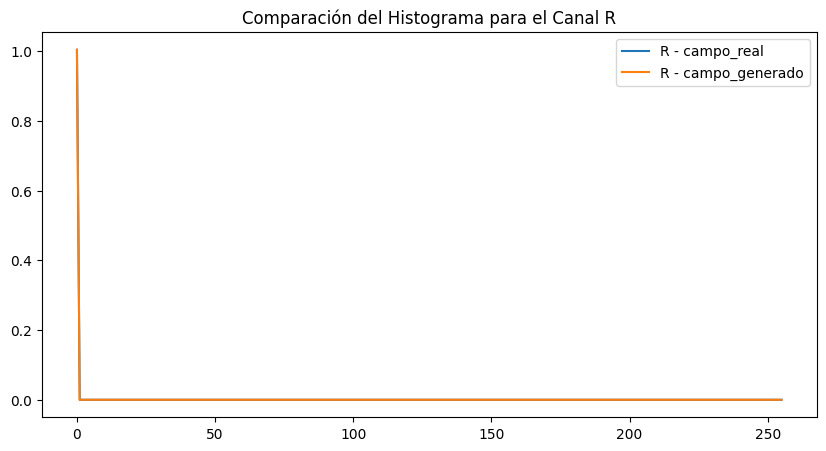

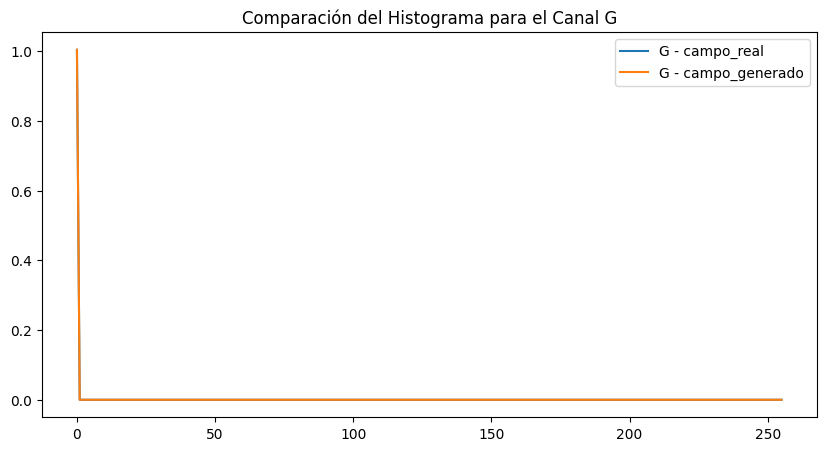

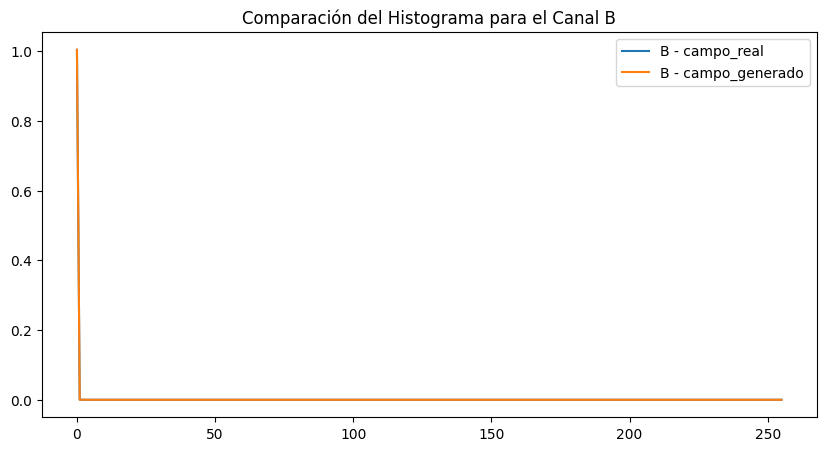

Bhattacharyya distance for R channel: 1.003921568627451
Bhattacharyya distance for G channel: 1.003921568627451
Bhattacharyya distance for B channel: 1.003917818083456


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def compute_histogram(tensor, bins=256):
    """
    Calcula el histograma de un tensor de imagen en cada canal RGB.

    :param tensor: Imagen en formato [C, H, W]
    :param bins: Número de bins para el histograma
    :return: Lista de histogramas para cada canal
    """
    # Convertir de tensor a numpy array [C, H, W] -> [H, W, C]
    img = tensor.permute(1, 2, 0).cpu().numpy()

    histograms = []
    for c in range(3):  # Para cada canal (RGB)
        hist, _ = np.histogram(img[..., c], bins=bins, range=(0, 255), density=True)
        histograms.append(hist)

    return histograms

def bhattacharyya_distance(hist1, hist2):
    """
    Calcula la distancia de Bhattacharyya entre dos histogramas.

    :param hist1: Histograma de la primera imagen
    :param hist2: Histograma de la segunda imagen
    :return: Distancia de Bhattacharyya
    """
    return np.sum(np.sqrt(hist1 * hist2))

# Calcular los histogramas de las dos imágenes
campo_real_histograms = compute_histogram(campo_real_tensor)
campo_generado_histograms = compute_histogram(campo_generado_tensor)

# Comparar los histogramas entre campo_real_tensor y campo_generado_tensor
bhattacharyya_scores = []
for h1, h2 in zip(campo_real_histograms, campo_generado_histograms):
    bhattacharyya_score = bhattacharyya_distance(h1, h2)
    bhattacharyya_scores.append(bhattacharyya_score)

# Mostrar los histogramas de las imágenes
channels = ['R', 'G', 'B']
for i, (h1, h2) in enumerate(zip(campo_real_histograms, campo_generado_histograms)):
    plt.figure(figsize=(10, 5))
    plt.plot(h1, label=f'{channels[i]} - campo_real')
    plt.plot(h2, label=f'{channels[i]} - campo_generado')
    plt.title(f'Comparación del Histograma para el Canal {channels[i]}')
    plt.legend()
    plt.show()

# Imprimir la distancia de Bhattacharyya para cada canal
for i, score in enumerate(bhattacharyya_scores):
    print(f"Bhattacharyya distance for {channels[i]} channel: {score}")


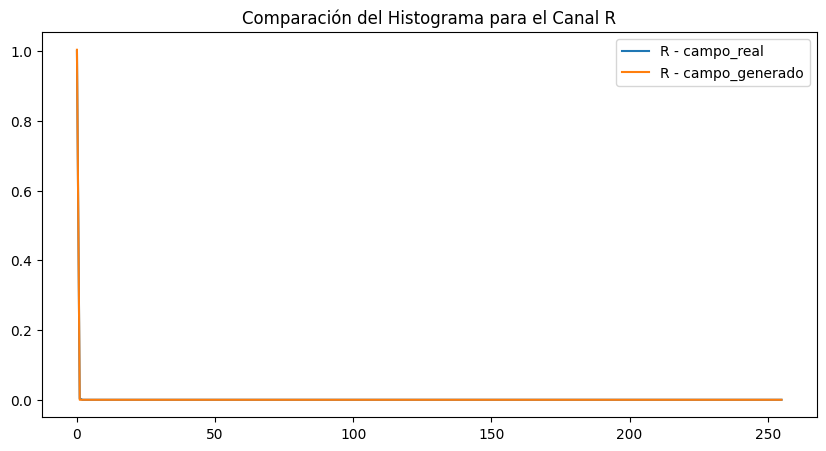

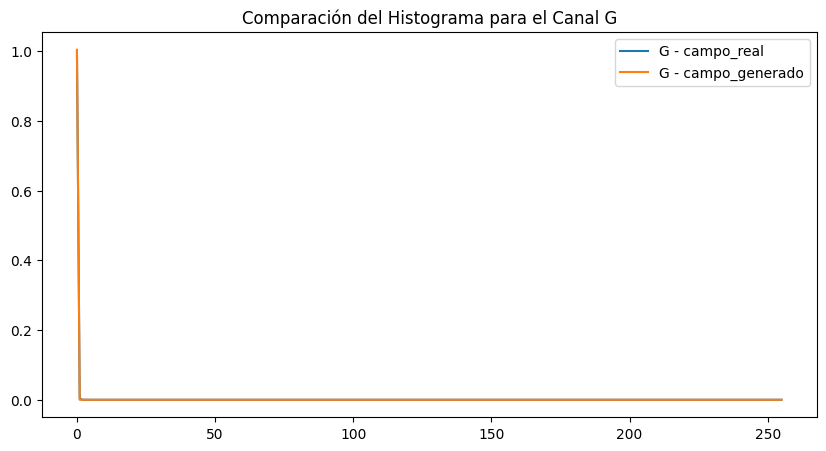

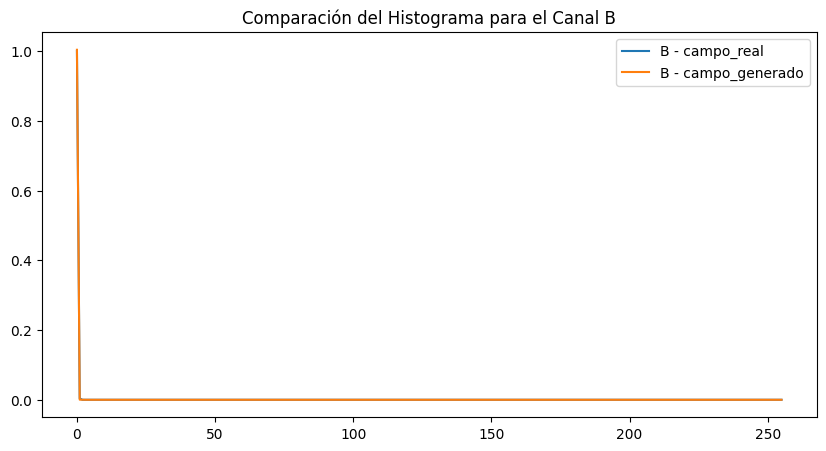

Bhattacharyya distance for R channel: 1.0020029875901062
Bhattacharyya distance for G channel: 1.0019357063962844
Bhattacharyya distance for B channel: 1.0029156355921955


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def compute_histogram(tensor, bins=256):
    """
    Calcula el histograma de un tensor de imagen en cada canal RGB.

    :param tensor: Imagen en formato [C, H, W]
    :param bins: Número de bins para el histograma
    :return: Lista de histogramas para cada canal
    """
    # Convertir de tensor a numpy array [C, H, W] -> [H, W, C]
    img = tensor.permute(1, 2, 0).cpu().numpy()

    histograms = []
    for c in range(3):  # Para cada canal (RGB)
        hist, _ = np.histogram(img[..., c], bins=bins, range=(0, 255), density=True)
        histograms.append(hist)

    return histograms

def bhattacharyya_distance(hist1, hist2):
    """
    Calcula la distancia de Bhattacharyya entre dos histogramas.

    :param hist1: Histograma de la primera imagen
    :param hist2: Histograma de la segunda imagen
    :return: Distancia de Bhattacharyya
    """
    return np.sum(np.sqrt(hist1 * hist2))

# Calcular los histogramas de las dos imágenes
campo_real_histograms = compute_histogram(dummy_picture_torch)
campo_generado_histograms = compute_histogram(campo_generado_tensor)

# Comparar los histogramas entre campo_real_tensor y campo_generado_tensor
bhattacharyya_scores = []
for h1, h2 in zip(campo_real_histograms, campo_generado_histograms):
    bhattacharyya_score = bhattacharyya_distance(h1, h2)
    bhattacharyya_scores.append(bhattacharyya_score)

# Mostrar los histogramas de las imágenes
channels = ['R', 'G', 'B']
for i, (h1, h2) in enumerate(zip(campo_real_histograms, campo_generado_histograms)):
    plt.figure(figsize=(10, 5))
    plt.plot(h1, label=f'{channels[i]} - campo_real')
    plt.plot(h2, label=f'{channels[i]} - campo_generado')
    plt.title(f'Comparación del Histograma para el Canal {channels[i]}')
    plt.legend()
    plt.show()

# Imprimir la distancia de Bhattacharyya para cada canal
for i, score in enumerate(bhattacharyya_scores):
    print(f"Bhattacharyya distance for {channels[i]} channel: {score}")


#Sexto Método - Error Cuadrático Medio (MSE)

In [ ]:
import torch

def compute_mse(tensor1, tensor2):
    """
    Calcula el error cuadrático medio (MSE) entre dos tensores de imagen.

    :param tensor1: Tensor de la primera imagen
    :param tensor2: Tensor de la segunda imagen
    :return: Valor del MSE
    """
    # Asegurarse de que los tensores sean del mismo tamaño
    if tensor1.shape != tensor2.shape:
        raise ValueError(f"Los tensores deben tener el mismo tamaño, pero se recibieron tamaños {tensor1.shape} y {tensor2.shape}")

    # Calcular el error cuadrático medio
    mse = torch.mean((tensor1 - tensor2) ** 2)

    return mse.item()  # Convertir el tensor a un valor escalar

# Calcular el MSE entre las dos imágenes
mse_value = compute_mse(campo_real_tensor, campo_generado_tensor)

# Mostrar el resultado
print(f"Error Cuadrático Medio (MSE): {mse_value}")


Error Cuadrático Medio (MSE): 0.000252963334787637


In [ ]:
import torch

def compute_mse(tensor1, tensor2):
    """
    Calcula el error cuadrático medio (MSE) entre dos tensores de imagen.

    :param tensor1: Tensor de la primera imagen
    :param tensor2: Tensor de la segunda imagen
    :return: Valor del MSE
    """
    # Asegurarse de que los tensores sean del mismo tamaño
    if tensor1.shape != tensor2.shape:
        raise ValueError(f"Los tensores deben tener el mismo tamaño, pero se recibieron tamaños {tensor1.shape} y {tensor2.shape}")

    # Calcular el error cuadrático medio
    mse = torch.mean((tensor1 - tensor2) ** 2)

    return mse.item()  # Convertir el tensor a un valor escalar

# Calcular el MSE entre las dos imágenes
mse_value = compute_mse(dummy_picture_torch, campo_generado_tensor)

# Mostrar el resultado
print(f"Error Cuadrático Medio (MSE): {mse_value}")


Error Cuadrático Medio (MSE): 0.14989660680294037


In [ ]:
import torch

def compute_mse(tensor1, tensor2):
    """
    Calcula el error cuadrático medio (MSE) entre dos tensores de imagen.

    :param tensor1: Tensor de la primera imagen
    :param tensor2: Tensor de la segunda imagen
    :return: Valor del MSE
    """
    # Asegurarse de que los tensores sean del mismo tamaño
    if tensor1.shape != tensor2.shape:
        raise ValueError(f"Los tensores deben tener el mismo tamaño, pero se recibieron tamaños {tensor1.shape} y {tensor2.shape}")

    # Calcular el error cuadrático medio
    mse = torch.mean((tensor1 - tensor2) ** 2)

    return mse.item()  # Convertir el tensor a un valor escalar

# Calcular el MSE entre las dos imágenes
mse_value = compute_mse(campo_real_tensor, dummy_picture_torch)

# Mostrar el resultado
print(f"Error Cuadrático Medio (MSE): {mse_value}")


Error Cuadrático Medio (MSE): 0.15131857991218567


#Séptimo Método - Error Cuadrático Absluto (MAE)

In [ ]:
import torch

def compute_mae(tensor1, tensor2):
    """
    Calcula el error cuadrático absoluto (MAE) entre dos tensores de imagen.

    :param tensor1: Tensor de la primera imagen
    :param tensor2: Tensor de la segunda imagen
    :return: Valor del MAE
    """
    # Asegurarse de que los tensores sean del mismo tamaño
    if tensor1.shape != tensor2.shape:
        raise ValueError(f"Los tensores deben tener el mismo tamaño, pero se recibieron tamaños {tensor1.shape} y {tensor2.shape}")

    # Calcular el error cuadrático absoluto
    mae = torch.mean(torch.abs(tensor1 - tensor2))

    return mae.item()  # Convertir el tensor a un valor escalar

# Calcular el MAE entre las dos imágenes
mae_value = compute_mae(campo_real_tensor, campo_generado_tensor)

# Mostrar el resultado
print(f"Error Cuadrático Absoluto (MAE): {mae_value}")


Error Cuadrático Absoluto (MAE): 0.011005156673491001


In [ ]:
import torch

def compute_mae(tensor1, tensor2):
    """
    Calcula el error cuadrático absoluto (MAE) entre dos tensores de imagen.

    :param tensor1: Tensor de la primera imagen
    :param tensor2: Tensor de la segunda imagen
    :return: Valor del MAE
    """
    # Asegurarse de que los tensores sean del mismo tamaño
    if tensor1.shape != tensor2.shape:
        raise ValueError(f"Los tensores deben tener el mismo tamaño, pero se recibieron tamaños {tensor1.shape} y {tensor2.shape}")

    # Calcular el error cuadrático absoluto
    mae = torch.mean(torch.abs(tensor1 - tensor2))

    return mae.item()  # Convertir el tensor a un valor escalar

# Calcular el MAE entre las dos imágenes
mae_value = compute_mae(dummy_picture_torch, campo_generado_tensor)

# Mostrar el resultado
print(f"Error Cuadrático Absoluto (MAE): {mae_value}")


Error Cuadrático Absoluto (MAE): 0.316582590341568


In [ ]:
import torch

def compute_mae(tensor1, tensor2):
    """
    Calcula el error cuadrático absoluto (MAE) entre dos tensores de imagen.

    :param tensor1: Tensor de la primera imagen
    :param tensor2: Tensor de la segunda imagen
    :return: Valor del MAE
    """
    # Asegurarse de que los tensores sean del mismo tamaño
    if tensor1.shape != tensor2.shape:
        raise ValueError(f"Los tensores deben tener el mismo tamaño, pero se recibieron tamaños {tensor1.shape} y {tensor2.shape}")

    # Calcular el error cuadrático absoluto
    mae = torch.mean(torch.abs(tensor1 - tensor2))

    return mae.item()  # Convertir el tensor a un valor escalar

# Calcular el MAE entre las dos imágenes
mae_value = compute_mae(campo_real_tensor, dummy_picture_torch)

# Mostrar el resultado
print(f"Error Cuadrático Absoluto (MAE): {mae_value}")


Error Cuadrático Absoluto (MAE): 0.31800296902656555


#Octavo Método - Entropía Cruzada - PÉSIMO



El uso de entropía cruzada como métrica para analizar la similitud entre las imágenes es una idea interesante, aunque no es el enfoque más común. La entropía cruzada es una métrica estadística que mide la disimilitud entre dos distribuciones probabilísticas. Para aplicarla en imágenes, debes interpretar cada imagen como una distribución de probabilidades.

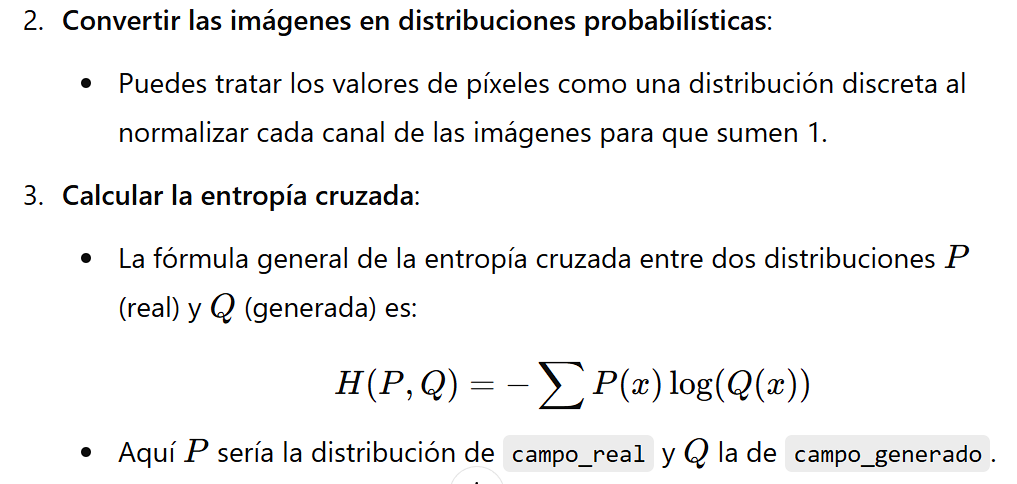

In [ ]:
import torch
import torch.nn.functional as F

# Asegúrate de que los tensores sean del mismo tamaño
assert campo_generado_tensor.shape == campo_real_tensor.shape, "Las imágenes deben tener las mismas dimensiones"

# Paso 1: Normalizar cada canal de las imágenes
campo_generado_probs = campo_generado_tensor / campo_generado_tensor.sum(dim=(1, 2), keepdim=True)
campo_real_probs = campo_real_tensor / campo_real_tensor.sum(dim=(1, 2), keepdim=True)

# Paso 2: Calcular la entropía cruzada
# Añadimos una pequeña constante (epsilon) para evitar log(0)
epsilon = 1e-12
cross_entropy = -torch.sum(campo_real_probs * torch.log(campo_generado_probs + epsilon))

print("Entropía cruzada entre las imágenes:", cross_entropy.item())


Entropía cruzada entre las imágenes: 39.183162689208984


In [ ]:
import torch
import torch.nn.functional as F

# Asegúrate de que los tensores sean del mismo tamaño
assert campo_generado_tensor.shape == campo_real_tensor.shape, "Las imágenes deben tener las mismas dimensiones"

# Paso 1: Normalizar cada canal de las imágenes
dummy_picture_torch_probs = dummy_picture_torch / dummy_picture_torch.sum(dim=(1, 2), keepdim=True)
campo_real_probs = campo_real_tensor / campo_real_tensor.sum(dim=(1, 2), keepdim=True)

# Paso 2: Calcular la entropía cruzada
# Añadimos una pequeña constante (epsilon) para evitar log(0)
epsilon = 1e-12
cross_entropy = -torch.sum(campo_real_probs * torch.log(dummy_picture_torch_probs + epsilon))

print("Entropía cruzada entre las imágenes:", cross_entropy.item())

Entropía cruzada entre las imágenes: 40.335121154785156


In [ ]:
import torch
import torch.nn.functional as F

# Asegúrate de que los tensores sean del mismo tamaño
assert campo_generado_tensor.shape == campo_real_tensor.shape, "Las imágenes deben tener las mismas dimensiones"

# Paso 1: Normalizar cada canal de las imágenes
campo_generado_probs = campo_generado_tensor / campo_generado_tensor.sum(dim=(1, 2), keepdim=True)
dummy_picture_torch_probs = dummy_picture_torch / dummy_picture_torch.sum(dim=(1, 2), keepdim=True)

# Paso 2: Calcular la entropía cruzada
# Añadimos una pequeña constante (epsilon) para evitar log(0)
epsilon = 1e-12
cross_entropy = -torch.sum(dummy_picture_torch_probs * torch.log(campo_generado_probs + epsilon))

print("Entropía cruzada entre las imágenes:", cross_entropy.item())


Entropía cruzada entre las imágenes: 39.69535446166992
